In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)
input_steps = 6   
output_steps = 6  
features = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']


In [8]:
import pandas as pd
data_file = "data.csv"
df = pd.read_csv(data_file)
df.head()


,row,column,time,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0,114,2019-04-01 00:00:00,0.0,446.125,38.8750,-641.1130,-0.000014,0.588248,37.3602,...,-127783.0,0.019673,-11962.0,0.723206,49.2396,48.2194,25.7935,-3.60667,4.52345,7.32809
1,0,114,2019-04-01 02:00:00,9.2,519.750,73.3129,-201.3910,-0.000037,0.588248,36.5532,...,-292881.0,0.019673,-47450.0,0.696106,45.5470,44.8224,30.9666,-2.22687,6.66260,7.41515
2,0,114,2019-04-01 03:00:00,7.4,447.500,112.0940,-80.8945,-0.000043,0.588248,34.9319,...,-368528.0,0.019673,-52756.0,0.583984,44.9262,44.2858,30.6357,-2.50978,6.57468,7.14874
3,0,114,2019-04-01 04:00:00,0.0,421.500,158.5940,-33.9180,-0.000043,0.588248,32.5174,...,-330868.0,0.019673,-61373.0,0.633057,44.5228,43.8416,30.3324,-2.59560,6.28084,7.31476
4,0,114,2019-04-01 05:00:00,0.0,435.625,98.8282,11.6406,-0.000039,0.588248,31.7187,...,-336783.0,0.019673,-73801.0,0.654419,43.7452,43.0466,30.1800,-2.81416,5.87009,7.58484


In [9]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time').reset_index(drop=True)
df[features] = df[features].fillna(method='ffill')

# Thực hiện chuẩn hóa z-score cho từng feature
for col in features:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
df[features].describe()


C:\Users\Dell\AppData\Local\Temp\ipykernel_17888\867896340.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features] = df[features].fillna(method='ffill')


,AWS,CAPE,CIN,V850,KX,R250,R500,U250,U850,EWSS
count,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05,6.576810e+05
mean,-3.759708e-17,-8.228143e-17,-4.563508e-17,9.070836e-17,1.232839e-15,-1.581670e-16,5.531525e-18,2.814163e-16,-9.507308e-17,5.911817e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.611197e-01,-6.550794e-01,-1.090687e+00,-4.789700e+00,-7.231438e+00,-1.684630e+00,-1.683091e+00,-2.596013e+00,-5.029877e+00,-2.073052e+01
25%,-1.611197e-01,-6.526251e-01,-1.052129e+00,-5.261228e-01,-2.727870e-01,-8.469784e-01,-8.988603e-01,-8.751771e-01,-6.300305e-01,-2.726430e-01
50%,-1.611197e-01,-5.386114e-01,9.614154e-01,2.378488e-01,2.444142e-01,-1.699959e-01,-1.051355e-01,-2.124731e-01,5.540092e-04,1.344870e-01
75%,-1.611197e-01,3.018772e-01,9.614154e-01,6.696491e-01,6.307298e-01,7.724876e-01,8.372264e-01,9.106926e-01,7.593531e-01,3.606374e-01
max,5.367483e+01,7.129759e+00,9.614154e-01,2.504908e+00,1.949195e+00,2.586575e+00,2.251946e+00,2.549776e+00,2.968055e+00,1.114978e+01


In [10]:
def create_sequences(data, input_steps, output_steps):
    """
    Hàm tạo chuỗi dữ liệu cho bài toán dự báo đa bước.
    Input:
      - data: mảng 2D có shape (T, num_features) với T là số thời điểm.
      - input_steps: số bước thời gian đầu vào
      - output_steps: số bước thời gian cần dự báo
    Output:
      - X: mảng đầu vào với shape (samples, input_steps, num_features)
      - y: mảng nhãn với shape (samples, output_steps, num_features)
    """
    X, y = [], []
    total_steps = input_steps + output_steps
    for i in range(len(data) - total_steps + 1):
        X.append(data[i:i+input_steps, :])
        y.append(data[i+input_steps:i+total_steps, :])
    return np.array(X), np.array(y)

# Lấy dữ liệu các feature (loại bỏ cột datetime)
data_array = df[features].values


X_seq, y_seq = create_sequences(data_array, input_steps, output_steps)

print("Shape của X_seq:", X_seq.shape)
print("Shape của y_seq:", y_seq.shape)


Shape của X_seq: (657670, 6, 10)
Shape của y_seq: (657670, 6, 10)


In [11]:
num_samples = X_seq.shape[0]
train_size = int(num_samples * 0.8)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]


print("Số mẫu Train:", X_train.shape[0])
print("Số mẫu Test:", X_test.shape[0])


Số mẫu Train: 526136
Số mẫu Test: 131534


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(input_steps, len(features))))
model.add(LSTM(50, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(len(features))))
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 6, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 6, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 6, 10)          │           510 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,910 (128.55 KB)

 Trainable params: 32,910 (128.55 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 74s 8ms/step - loss: 0.3225 - val_loss: 0.2316
Epoch 2/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2838 - val_loss: 0.3351
Epoch 3/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2796 - val_loss: 0.3751
Epoch 4/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2772 - val_loss: 0.3977
Epoch 5/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2757 - val_loss: 0.4156
Epoch 6/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2746 - val_loss: 0.4298
Epoch 7/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2737 - val_loss: 0.4356
Epoch 8/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2731 - val_loss: 0.4366
Epoch 9/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2726 - val_loss: 0.4377
Epoch 10/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2721 - val_loss: 0.4405
Epoch 11/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.2717 - val_loss: 0.4452
Epoch 12

In [12]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)
y_pred = model.predict(X_test)
y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

mse = np.mean((y_test_flat - y_pred_flat)**2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, y_pred_flat)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Hoặc tính MSE riêng cho từng bước thời gian (nếu cần)
for i in range(output_steps):
    mse_i = mean_squared_error(y_test[:, i, :], y_pred[:, i, :])
    print(f"MSE cho bước dự báo thứ {i+1}: {mse_i}")


NameError: name 'model' is not defined

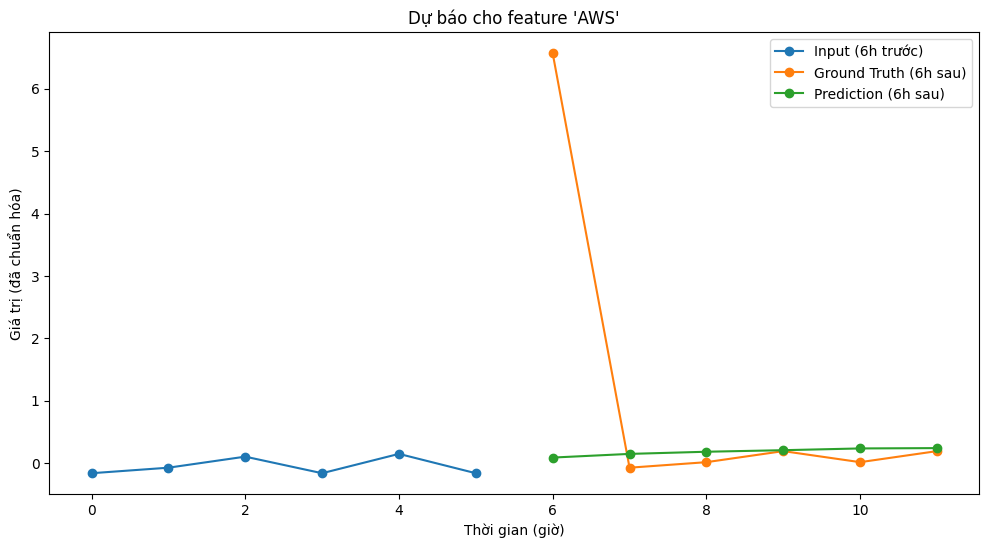

In [ ]:
feature_index = 0
sample_index = np.random.randint(0, X_test.shape[0])
input_sequence = X_test[sample_index]      
ground_truth = y_test[sample_index]         
prediction = y_pred[sample_index]             
plt.figure(figsize=(12,6))
plt.plot(range(0, input_steps), input_sequence[:, feature_index], marker='o', label='Input (6h trước)')
plt.plot(range(input_steps, input_steps+output_steps), ground_truth[:, feature_index], marker='o', label='Ground Truth (6h sau)')
plt.plot(range(input_steps, input_steps+output_steps), prediction[:, feature_index], marker='o', label='Prediction (6h sau)')
plt.xlabel("Thời gian (giờ)")
plt.ylabel("Giá trị (đã chuẩn hóa)")
plt.title("Dự báo cho feature 'AWS'")
plt.legend()
plt.show()


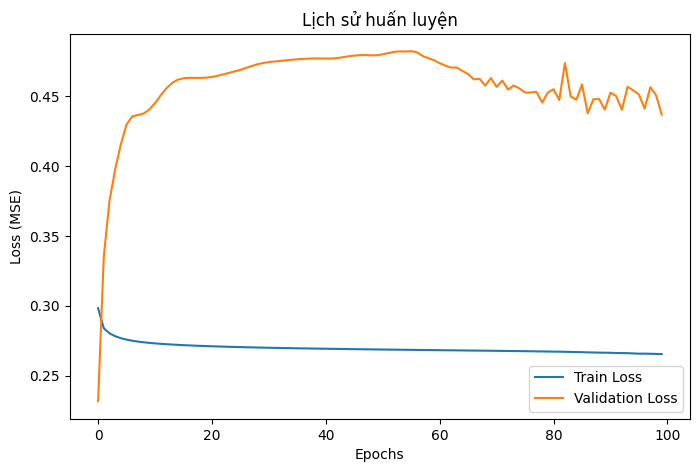

In [50]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Lịch sử huấn luyện")
plt.legend()
plt.show()
